### Currently, this notebook is used for:
    - validating the different normalization approaches currently used/tested

### Set up

In [86]:
import warnings
warnings.filterwarnings('once')

In [87]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.animation as anim
import matplotlib.cm as cm
from numpy.matlib import repmat
import seaborn as sns
import itertools
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean

import sys # so that we can import model_responses (in different folder)
import model_responses as mod_resp

# %matplotlib inline

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

## fixed
conDig = 3; # round contrast to the 3rd digit
# at CNS
basePath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/';
# personal mac
# basePath = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/';

## edit
expDir   = 'V1/';
fullWaveform = 0;
which_cell = 3; # which cell - index will be which_cell - 1
df_dogType = 1; # 0 - not DoG; 1 - Sach; 2 - Tony
df_lossType = 3; # 1 - lsq; 2 - sqrt; 3 - poiss; 4 - sach

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = np.load(dataPath + 'dataList.npy', encoding='latin1').item();
expInd, expType = hf.get_exp_ind(dataPath, dataList['unitName'][which_cell-1])

if df_dogType == 0:
    df_suff = ''
elif df_dogType == 1:
    df_suff = 'sach'
elif df_dogType == 2:
    df_suff = 'tony'
dfName = hf.descrFit_name(df_lossType, df_suff);

In [88]:
expInd, dataList['unitName'][which_cell-1], expType

(4, 'm676p3l07', 'sfMixInt')

Now, load the rvc/phFits, if applicable, and prepare to load the 

In [89]:
rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell);
phFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName='phaseAdvanceFits');

In [90]:
cellStruct = np.load(dataPath + dataList['unitName'][which_cell-1] + '_sfm.npy', encoding='latin1').item();
data = cellStruct['sfm']['exp']['trial'];

In [91]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     
rcParams['lines.linewidth'] = 2.5;
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;
rcParams['font.style'] = 'oblique';

# also, fix warnings so they don't repeat
import warnings
warnings.filterwarnings('once')

### Organize data
#### determine contrasts, center spatial frequency, dispersions

In [92]:
data = cellStruct['sfm']['exp']['trial'];

resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = hf.tabulate_responses(data, expInd);

all_disps = stimVals[0];
all_cons = stimVals[1];
all_sfs = stimVals[2];

nCons = len(all_cons);
nSfs = len(all_sfs);
nDisps = len(all_disps);

#### Unpack responses

In [93]:
respMean = resp[0];
respStd = resp[1];
predMean = resp[2];
predStd = resp[3];
# f1Mean = resp[4];
# f1Std = resp[5];
# predF1mean = resp[6];
# predF1std = resp[7];
rM_summary = np.reshape([np.sum(x) for x in respMean.flatten()], respMean.shape)
rS_summary = np.reshape([np.sqrt(np.sum(np.square(x))) for x in respStd.flatten()], respStd.shape)

#### Get model parameters

In [94]:
fitBase = 'fitList_190321c_';
wght = hf.np_smart_load(dataPath + fitBase + 'wght_chiSq.npy')[which_cell-1]['params'];
flat = hf.np_smart_load(dataPath + fitBase + 'flat_chiSq.npy')[which_cell-1]['params'];

## Analyze normalization

The normalization response - in full - is nFrames x nTrials. In the original normalization calculation, that means that we first sum over all the normalization filters; in the new normalization calculation, which is constant for all frames in a given trial, this means we broadcast the (general) resposne to all frames.

First, we compute the normalization weighting for the original method:

In [95]:
T = cellStruct['sfm'];
nInhChan = T['mod']['normalization']['pref']['sf'];
nTrials = len(T['exp']['trial']['num']);
nFrames = hf.num_frames(expInd);
# weighted
[norm_mean, norm_std] = [wght[-2], wght[-1]]
inhWeight_wght = hf.genNormWeights(cellStruct, nInhChan, norm_mean, norm_std, nTrials, expInd);
# 
inhWeightFlat = [];
for iP in range(len(nInhChan)):
    inhAsym = 0;
    inhWeightFlat = np.append(inhWeightFlat, 1 + inhAsym*(np.log(T['mod']['normalization']['pref']['sf'][iP]) \
                                          - np.mean(np.log(T['mod']['normalization']['pref']['sf'][iP]))));
# assumption by creation (made by Robbe) - only two normalization pools                                                                                                                               
inhWeightT1 = np.reshape(inhWeightFlat, (1, len(inhWeightFlat)));
inhWeightT2 = repmat(inhWeightT1, nTrials, 1);
inhWeightT3 = np.reshape(inhWeightT2, (nTrials, len(inhWeightFlat), 1));
inhWeight_flat  = np.tile(inhWeightT3, (1,1,nFrames));

Then, compute the new/simplified normalization weights

In [96]:
inhwt_flat = hf.genNormWeightsSimple(cellStruct, None, None)
inhwt_wght = hf.genNormWeightsSimple(cellStruct, norm_mean, norm_std)

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


Now, plot the weights, alone

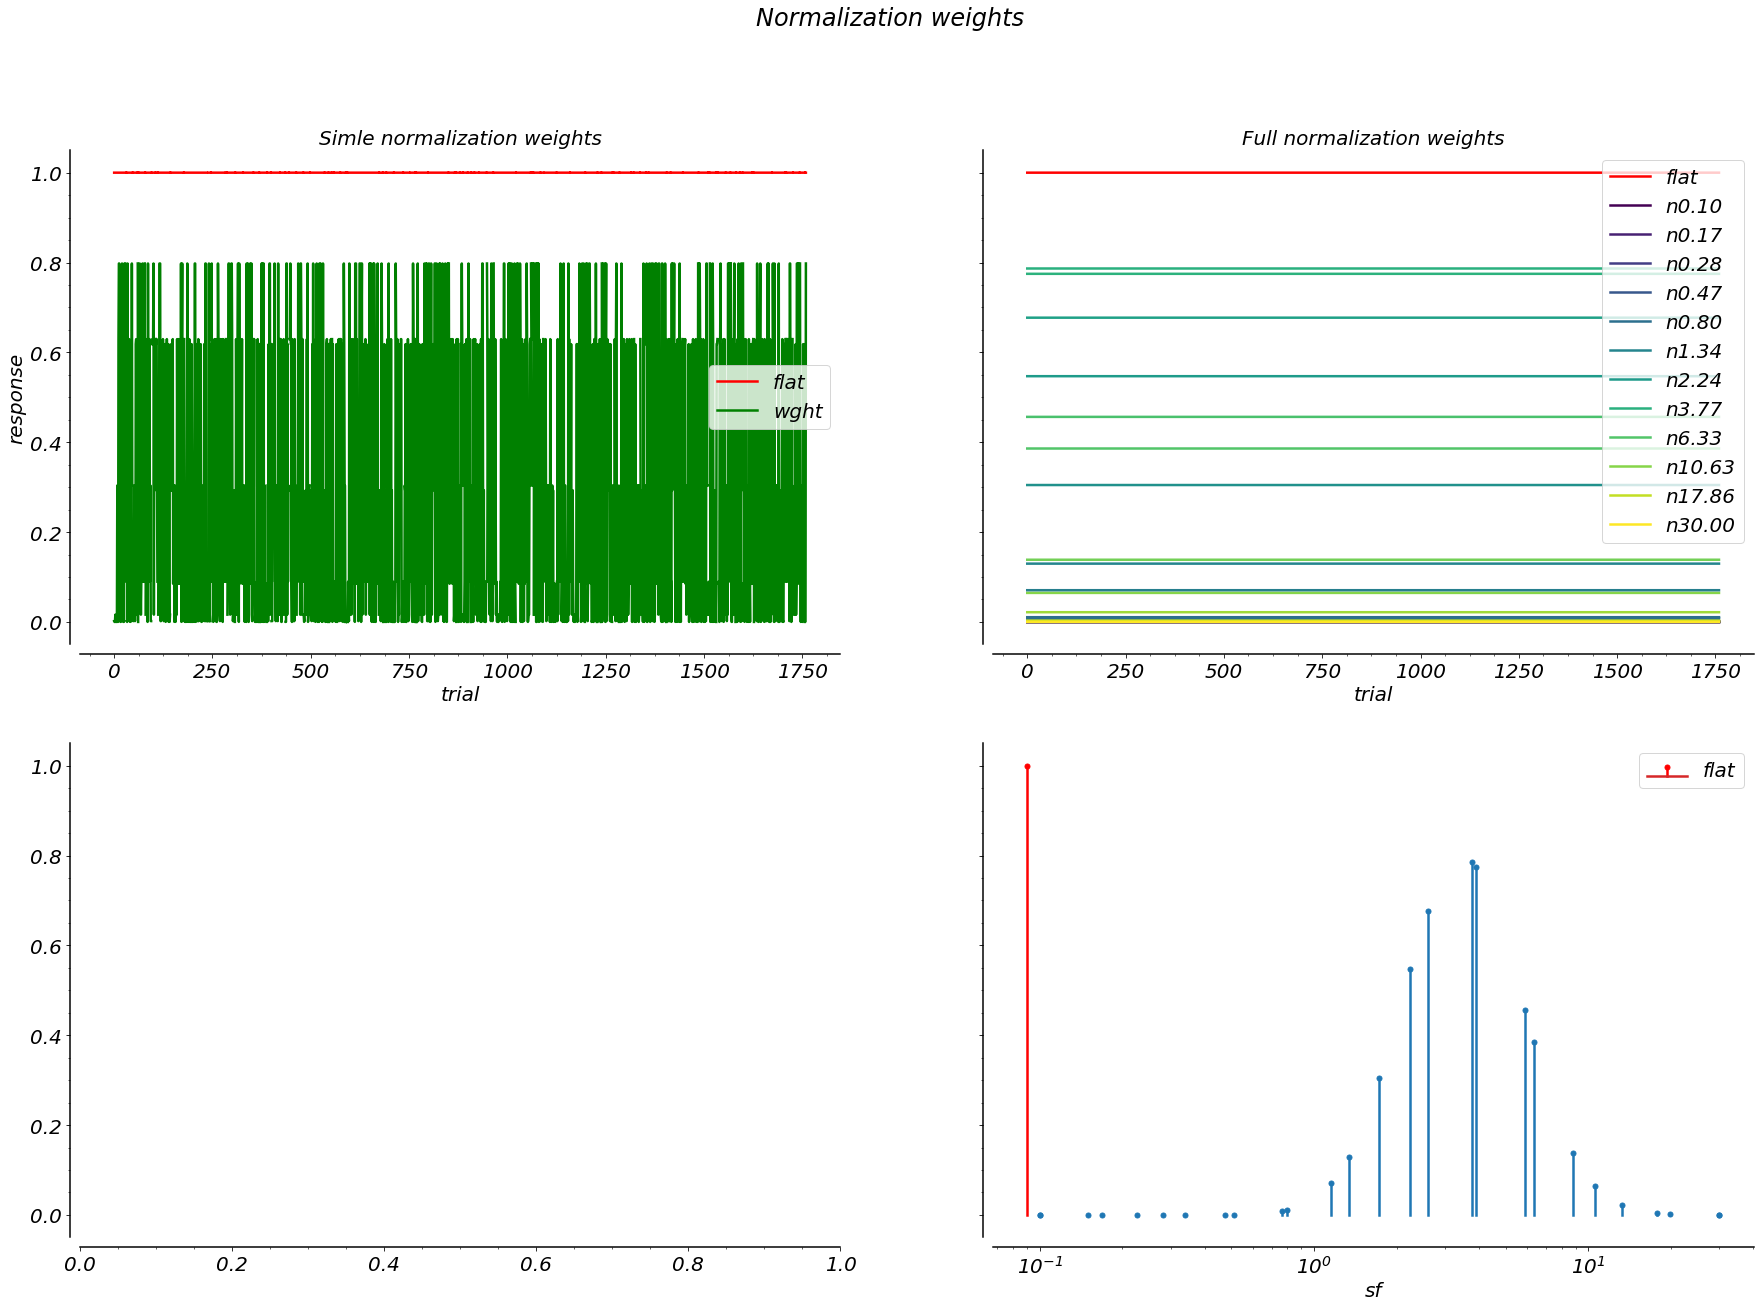

In [293]:
# how many frames?
frames = np.arange(len(inhWeight_flat[:, 10, 0]))

# filter colors - [broad, narrow]
[n_broad, n_narrow] = [len(T['mod']['normalization']['pref']['sf'][i]) for i in range(2)]
broad  = cm.viridis(np.linspace(0, 1, n_broad))
narrow = cm.viridis(np.linspace(0, 1, n_narrow))
colorscale = cm.viridis(np.linspace(0, 1, n_narrow));
filt_colors = np.vstack((broad, narrow))
narrow_sf = ['n%.2f'% x for x in T['mod']['normalization']['pref']['sf'][0]]
broad_sf = ['' % x for x in T['mod']['normalization']['pref']['sf'][1]]
f_sf = np.hstack((narrow_sf, broad_sf))
sf_vals = np.hstack((T['mod']['normalization']['pref']['sf'][0], T['mod']['normalization']['pref']['sf'][1]))

f, ax = plt.subplots(2, 2, figsize=(30, 20), sharey=True);
ax[0, 0].plot(inhwt_flat[0, :], 'r', label='flat'); # same for all components, all trials
ax[0, 0].plot(inhwt_wght[0, :], 'g', label='wght'); # same set of values for all components, different across trials
ax[0, 0].set_xlabel('trial')
ax[0, 0].set_ylabel('response')
ax[0, 0].set_title('Simle normalization weights')
ax[0, 0].legend();

ax[0, 1].plot(frames, inhWeight_flat[:, 0, 0], 'r', label='flat'); # always 1...
# for weighted norm, weight varies by filter, but within filter, is same for all trials/frames 
[ax[0, 1].plot(inhWeight_wght[:, filt, 0], color=fc, label=fsf) for filt,fc,fsf in zip(range(len(filt_colors)), filt_colors, f_sf)];
ax[0, 1].set_xlabel('trial')
ax[0, 1].set_title('Full normalization weights')
ax[0, 1].legend();

ax[1, 1].stem([0.9e-1], np.unique(inhWeight_flat), 'r', 'ro', label='flat'); # always 1...# for weighted norm, weight varies by filter, but within filter, is same for all trials/frames 
[ax[1, 1].stem([sf], np.unique(inhWeight_wght[:, filt, :]), basecol=fc) for sf,filt,fc,fsf in zip(sf_vals, range(len(filt_colors)), filt_colors, f_sf)];
ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel('sf')
ax[1, 1].legend();

f.suptitle('Normalization weights')
sns.despine(f, offset=10)

In [294]:
# that is
# simple_resp will be nFrames x nTrials; this is Linh in SFMGiveBof equation/calculation
simple_resp_wght = mod_resp.SimpleNormResp(cellStruct, expInd, norm_mean, norm_std)
simple_resp_flat = mod_resp.SimpleNormResp(cellStruct, expInd, None, None)
# full_resp will be nFrames x nTrials
full_resp_wght = np.sqrt((inhWeight_wght*T['mod']['normalization']['normResp']).sum(1)).transpose();
full_resp_flat = np.sqrt((inhWeight_flat*T['mod']['normalization']['normResp']).sum(1)).transpose();


/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


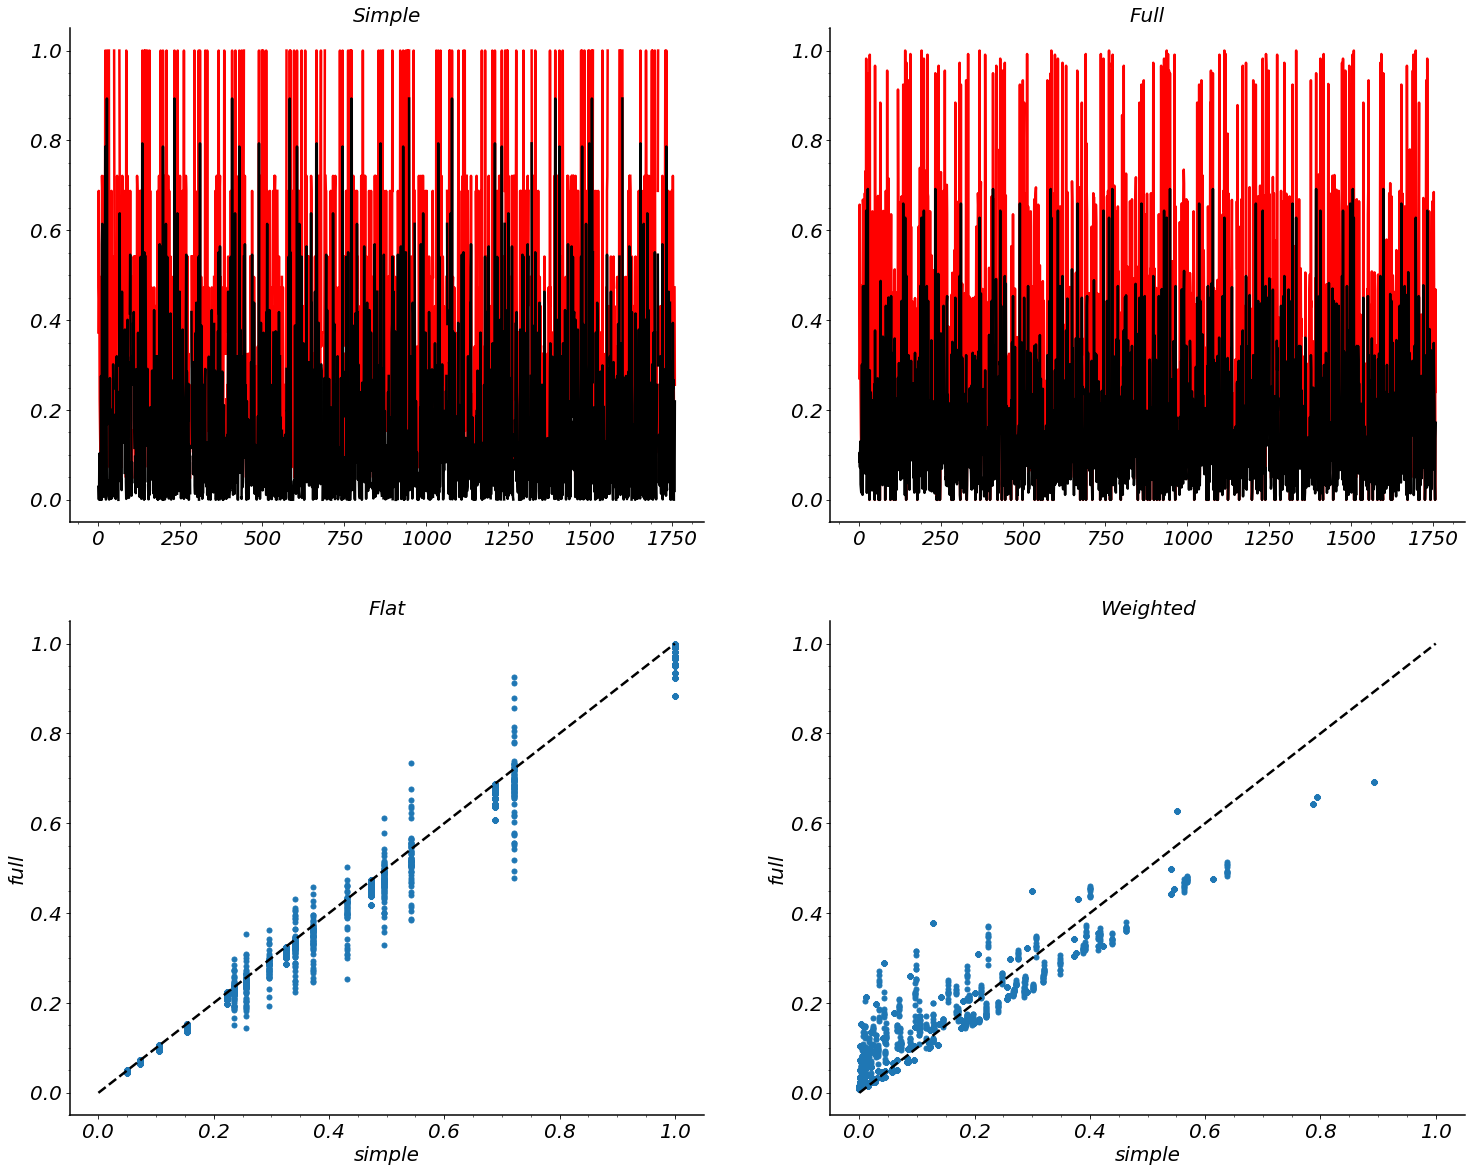

In [296]:
f, ax = plt.subplots(2, 2, figsize=(25, 20))
# simple
ax[0, 0].set_title('Simple')
ax[0, 0].plot(simple_resp_flat[10, :], 'r-', label='flat');
ax[0, 0].plot(simple_resp_wght[10, :], 'k-', label='wght');
# full
ax[0, 1].set_title('Full')
ax[0, 1].plot(full_resp_flat[10, :], 'r-', label='flat');
ax[0, 1].plot(full_resp_wght[10, :], 'k-', label='wght');
# flat: simple vs. full
ax[1, 0].set_title('Flat')
ax[1, 0].plot(simple_resp_flat[10, :], full_resp_flat[10, :], 'o');
ax[1, 0].plot([0, 1], [0, 1], 'k--')
ax[1, 0].set_xlabel('simple')
ax[1, 0].set_ylabel('full')
# wght: simple vs. full
ax[1, 1].set_title('Weighted')
ax[1, 1].plot(simple_resp_wght[10, :], full_resp_wght[10, :], 'o');
ax[1, 1].plot([0, 1], [0, 1], 'k--')
ax[1, 1].set_xlabel('simple');
ax[1, 1].set_ylabel('full');